In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv("anes_merged_subset.csv", low_memory=False)

print("Initial shape of df:", df.shape)
print("Columns in df:\n", df.columns.tolist())

Initial shape of df: (2839, 62)
Columns in df:
 ['2016 Immigration policy', '2020 For whom R voted (pre/early)', '2020 Media: TV mention', '2016 Feeling Therm: Rep Party', '2016 Death penalty (summary)', '2016 Voted in Nov election (post)', '2020 Media: Radio mention', '2016 Media: TV news mention', '2020 Party ID (basic)', '2020 Lib-Con 7pt scale', '2020 Media: Internet mention', '2020 Gun stance (difficulty buying)', '2016 Forced Lib or Con', 'Original (2016) Westat Case ID', '2016 Race summary', '2016 Media: Newspapers mention', '2016 Attention to news', '2016 For whom R voted (post)', '2016 ACA (2010 health care) favor/oppose', '2020 For whom R voted (post)', '2020 Feeling Therm: Dem Party', '2016 Post-election weight (full)', '2016 Attention to politics', '2020 Attention to politics', '2020 Where R is registered (pre)', '2016 Case ID', '2016 Feeling Therm: Dem Party', '2020 Voted in Nov election (post)', '2020 Media: Newspapers mention', '2016 Party ID summary', '2020 Interest in 

In [3]:
outcome_col = "2020 For whom R voted (post)"
df["vote_2020_binary"] = np.nan

df.loc[df[outcome_col] == 1, "vote_2020_binary"] = 1
df.loc[df[outcome_col] == 2, "vote_2020_binary"] = 0

# Drop rows that are not Dem/Rep or missing outcome
df = df.dropna(subset=["vote_2020_binary"])
df["vote_2020_binary"] = df["vote_2020_binary"].astype(int)

print("\nShape after filtering to Dem vs. Rep only:", df.shape)



Shape after filtering to Dem vs. Rep only: (2092, 63)


In [24]:
chosen_features = [
    "2020 Age (summary)",
    "2020 Education level",
    "2016 Race summar",
    "2020 Lib-Con 7pt scale",
    "2016 Immigration policy",
    "2020 Gun stance (difficulty buying)",
    "2016 ACA (2010 health care) favor/oppose",
    "2020 Attention to politics",
    "2016 Gun stance (make it more difficult)"
]

# Let's see which actually exist in df
useable_feats = [col for col in chosen_features if col in df.columns]
print("\nChosen features that exist in df:\n", useable_feats)

# Sentinel codes we want to treat as missing
sentinel_codes = [-9, -8, -4, -2, -1] 
df = df.replace(sentinel_codes, np.nan)


Chosen features that exist in df:
 ['2020 Age (summary)', '2020 Education level', '2020 Lib-Con 7pt scale', '2016 Immigration policy', '2020 Gun stance (difficulty buying)', '2016 ACA (2010 health care) favor/oppose', '2020 Attention to politics', '2016 Gun stance (make it more difficult)']


In [25]:
model_df = df.dropna(subset=useable_feats + ["vote_2020_binary"]).copy()
print("\nShape after dropping missing in outcome & chosen features:", model_df.shape)



Shape after dropping missing in outcome & chosen features: (2008, 63)


In [26]:
model_df = model_df[useable_feats+  ["vote_2020_binary"]]

Final X shape: (2008, 8)
Final y shape: (2008,)

--- MODEL EVALUATION ---
Accuracy: 0.835820895522388
Confusion matrix:
 [[146  31]
 [ 35 190]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       177
           1       0.86      0.84      0.85       225

    accuracy                           0.84       402
   macro avg       0.83      0.83      0.83       402
weighted avg       0.84      0.84      0.84       402



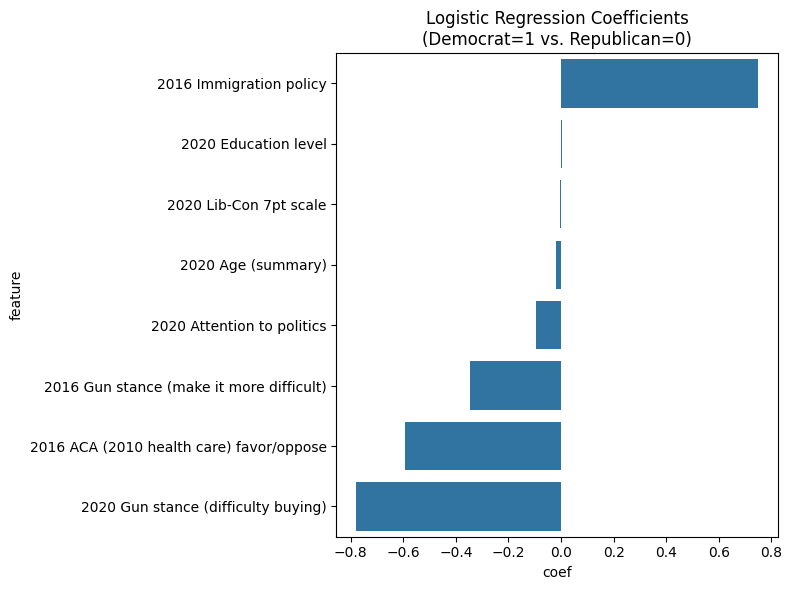

In [27]:
if model_df.shape[0] == 0:
    print("WARNING: No rows left after dropping missing values. "
          "You might need to remove or impute some columns.")
else:
    # (Optional) Convert party ID or race summary to categorical dummies
    cat_cols = []
    if "2020 Party ID (basic)" in useable_feats:
        cat_cols.append("2020 Party ID (basic)")
    if "2020 Race (summary)" in useable_feats:
        cat_cols.append("2020 Race (summary)")

    for cat_col in cat_cols:
        if cat_col in model_df.columns:
            model_df[cat_col] = model_df[cat_col].astype("category")

    model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

    # Final X, y
    X = model_df.drop(columns=["vote_2020_binary"])
    y = model_df["vote_2020_binary"].astype(int)

    print("Final X shape:", X.shape)
    print("Final y shape:", y.shape)

    ###############################################################################
    # STEP 5: TRAIN-TEST SPLIT & LOGISTIC REGRESSION
    ###############################################################################
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)

    # Predictions
    y_pred = lr.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0)

    print("\n--- MODEL EVALUATION ---")
    print("Accuracy:", acc)
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", cr)

    ###############################################################################
    # STEP 6: VISUALIZE & SAVE COEFFICIENTS
    ###############################################################################
    coef_vals = lr.coef_[0]
    feat_names = X.columns

    coef_df = pd.DataFrame({
        "feature": feat_names,
        "coef": coef_vals
    }).sort_values("coef", ascending=False)

    os.makedirs("figures", exist_ok=True)

    plt.figure(figsize=(8, 6))
    sns.barplot(x="coef", y="feature", data=coef_df, orient="h")
    plt.title("Logistic Regression Coefficients\n(Democrat=1 vs. Republican=0)")
    plt.tight_layout()
    plt.savefig("figures/logreg_coeffs.png", dpi=100)
    plt.show()

2016 Feeling Therm: Rep Party             0
2020 Lib-Con 7pt scale                    0
Original (2016) Westat Case ID            0
2020 For whom R voted (post)              0
2016 Post-election weight (full)          0
2016 Attention to politics                0
2020 Where R is registered (pre)          0
2016 Case ID                              0
2016 Feeling Therm: Dem Party             0
2020 Voted in Nov election (post)         0
2020 Already voted (pre)                  0
2020 Age (summary)                        0
2020 Case ID                              0
2016 Pre-election weight (full)           0
Panel post-election weight (2016-2020)    0
2020 Party ID summary                     0
2016 Interest in campaigns                0
2020 Mode of interview (pre)              0
Panel pre-election weight (2016-2020)     0
2020 Education level                      0
2016 Mode of interview                    0
vote_2020_binary                          0
2020 Party ID (basic)_2.0       